In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'RT', 'edu', 'use','refugee','afghan','https','co'])

In [6]:
# Import Dataset
df = pd.read_csv('input.csv','utf-8', skipinitialspace=True, delimiter=',',error_bad_lines=False,index_col=0)
print(df)
print(df.Sentence.unique())
#print(df)
df.head()

                                         Tag      Date  \
0.0            USA 1 January - 31 March 2020  31/03/20   
1.0            USA 1 January - 31 March 2020  31/03/20   
2.0            USA 1 January - 31 March 2020  31/03/20   
3.0            USA 1 January - 31 March 2020  31/03/20   
4.0            USA 1 January - 31 March 2020  31/03/20   
...                                      ...       ...   
13381.0  Australia June 1 - 31 December 2019  02/06/19   
NaN                                      NaN       NaN   
13382.0  Australia June 1 - 31 December 2019  02/06/19   
NaN                                      NaN       NaN   
13383.0  Australia June 1 - 31 December 2019  01/06/19   

                                                       URL        Influencer  \
0.0      http://twitter.com/ivonnegarza/statuses/124508...      @ivonnegarza   
1.0      http://twitter.com/isabelaalhadeff/statuses/12...  @isabelaalhadeff   
2.0      http://twitter.com/teresab313/statuses/1245072...     

,Tag,Date,URL,Influencer,Country,Sentence
0.0,USA 1 January - 31 March 2020,31/03/20,http://twitter.com/ivonnegarza/statuses/124508...,@ivonnegarza,United States,"UNHCR, IOM, OHCHR & WHO on the rights and heal..."
1.0,USA 1 January - 31 March 2020,31/03/20,http://twitter.com/isabelaalhadeff/statuses/12...,@isabelaalhadeff,United States,The UN Refugee Agency anticipates that the out...
2.0,USA 1 January - 31 March 2020,31/03/20,http://twitter.com/teresab313/statuses/1245072...,@teresab313,United States,"QT @AcereEleanor: Thread. On refugees, migrant..."
3.0,USA 1 January - 31 March 2020,31/03/20,http://twitter.com/CMSnewyork/statuses/1245071...,@CMSnewyork,United States,QT @AcereEleanor: Considering the lethal conse...
4.0,USA 1 January - 31 March 2020,31/03/20,http://twitter.com/AcereEleanor/statuses/12450...,@AcereEleanor,United States,"Instead of closing borders, UNHCR, OHCHR, WHO,..."


In [7]:
# Convert to list

df['data'] = df.Sentence.values.tolist()

df['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\_', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['data']]

# Remove new line characters
df['data'] = [re.sub('\s+', ' ', str(sent)) for sent in df['data']]

# Remove distracting single quotes
df['data'] = [re.sub("\'", " ", str(sent)) for sent in df['data']]

df['data']=df['data'].str.lower()
df['data'].unique()

array(['unhcr, iom, ohchr & who on the rights and health of #refugees #migrants #stateless it is vital that everyone, including all migrants and refugees, are ensured equal access to health services and are effectively included in national responses to covid19. https://t.co/wiphsmty8r https://t.co/7dpjniiqec',
       'the un refugee agency anticipates that the outflow of nicaraguans will continue to grow. but as a result of the coronavirus pandemic, they are unable to go back or move forward. when i first spoke to john mart√≠nez-picado after his deportation, he had been detained and tortured.',
       'qt acereeleanor: thread. on refugees, migrants and stateless persons. ; joint statement from ohchr, unhcr, iom, who addresses human rights rights at borders, release from detention & more. the rights and health of refugees, migrants and stateless must be protected in covid-19 response: https://t.co/zdcxqahmap via refugees',
       ...,
       ' kkeneally albomp congratulations on your ap

In [ ]:
df['data'] = df['data'].apply(lambda x: [item for item in x.split() if item not in stop_words])


In [8]:
data= df['data']

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['unhcr', 'iom', 'ohchr', 'who', 'on', 'the', 'rights', 'and', 'health', 'of', 'refugees', 'migrants', 'stateless', 'it', 'is', 'vital', 'that', 'everyone', 'including', 'all', 'migrants', 'and', 'refugees', 'are', 'ensured', 'equal', 'access', 'to', 'health', 'services', 'and', 'are', 'effectively', 'included', 'in', 'national', 'responses', 'to', 'covid', 'https', 'co', 'wiphsmty', 'https', 'co', 'dpjniiqec']]


In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['unhcr', 'iom', 'ohchr', 'who', 'on', 'the', 'rights', 'and', 'health', 'of', 'refugees', 'migrants', 'stateless', 'it', 'is', 'vital', 'that', 'everyone', 'including', 'all', 'migrants', 'and', 'refugees', 'are', 'ensured', 'equal', 'access', 'to', 'health_services', 'and', 'are', 'effectively', 'included', 'in', 'national', 'responses', 'to', 'covid', 'https', 'co', 'wiphsmty', 'https', 'co', 'dpjniiqec']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['refugee', 'migrant', 'stateless', 'vital', 'include', 'migrant', 'refugee', 'ensure', 'equal', 'access', 'health', 'service', 'effectively', 'include', 'national', 'response']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=80,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"migrant" + 0.022*"would" + 0.021*"camp" + 0.017*"provide" + '
  '0.014*"seawatch" + 0.013*"ekd" + 0.011*"new" + 0.010*"fluechtlinge" + '
  '0.010*"experience" + 0.010*"arrive"'),
 (1,
  '0.028*"government" + 0.020*"rescue" + 0.017*"ask" + 0.014*"right" + '
  '0.013*"welcome" + 0.012*"australian" + 0.012*"return" + 0.011*"border" + '
  '0.011*"yussuf" + 0.010*"care"'),
 (2,
  '0.127*"refugee" + 0.024*"people" + 0.015*"support" + 0.014*"year" + '
  '0.014*"child" + 0.012*"take" + 0.011*"help" + 0.010*"go" + 0.009*"world" + '
  '0.009*"withrefugee"'),
 (3,
  '0.027*"say" + 0.026*"country" + 0.017*"migrantcrisis" + 0.016*"auspol" + '
  '0.014*"boat" + 0.014*"asylum" + 0.014*"resettlement" + 0.013*"process" + '
  '0.013*"number" + 0.012*"call"')]


In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.219820456877876

Coherence Score:  0.37361970275491924


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.348786  0.012718       1        1  46.140778
3     -0.132304  0.254574       2        1  19.254656
1     -0.106294 -0.053168       3        1  17.820293
0     -0.110189 -0.214123       4        1  16.784264, topic_info=               Term         Freq        Total Category  logprob  loglift
8           refugee  9755.000000  9755.000000  Default  30.0000  30.0000
6           migrant  1401.000000  1401.000000  Default  29.0000  29.0000
321             say   867.000000   867.000000  Default  28.0000  28.0000
75       government   825.000000   825.000000  Default  27.0000  27.0000
62           people  1842.000000  1842.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3029           soon   168.940231   170.019745   Topic4  -5.1059   1.7784
11674           ekd   373.476349   378.454987   Topic4  -4.3125   1.7715
35           thread   150.545593   151.794708   Topic4  -5.2211   1.7765
8683   fluechtlinge   285.269104   304.475952   Topic4  -4.5820   1.7196
7299        frontex   229.083511   295.321777   Topic4  -4.8013   1.5307

[162 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1147      4  0.994524  accept
402       4  0.995452  accord
166       4  0.996879  agency
828       4  0.998423    also
3906      3  0.988981    anti
...     ...       ...     ...
137       1  0.999026   world
40        4  0.999055   would
201       1  0.999007    year
4983      1  0.003179  yussuf
4983      3  0.994873  yussuf

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

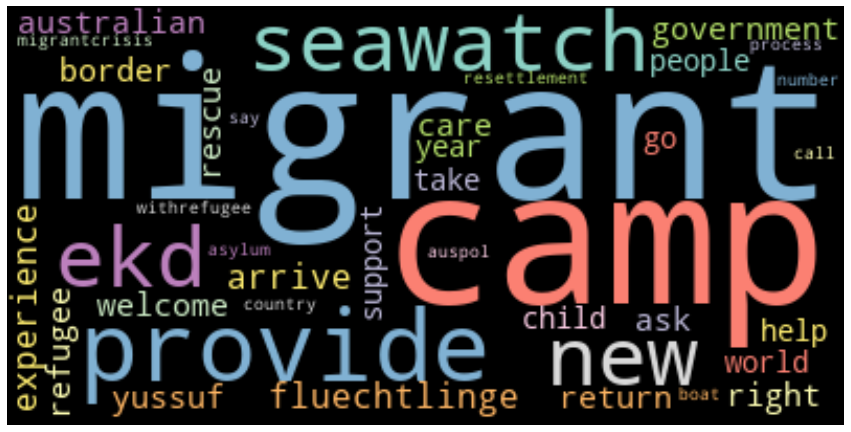

In [18]:
from wordcloud import WordCloud

from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.print_topics())
wordcloud = WordCloud(max_words=200,colormap='Set3', collocations=False,background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()